In [1]:
import numpy as np
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [7]:
par_mu = 5; par_sd = np.sqrt(1)
out_mu = 0; out_sd = np.sqrt(1)
true_alpha = [par_mu, par_sd]

n = 300
m = 3*n
eps = 0.1
par_reg1 = 0
par_reg2 = 0
exper_iter = 10
optim_iter = 500
L = 100
learn_par = 1
dicay_par = 0.5

def sigmoid(x):
    return 1/(np.exp(-x) + 1)

def deriv_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def g_up(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) + (t-s)**2/20

def g_lo(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) - (t-s)**2/20

In [8]:
res = [0 for i in range(exper_iter)]
for i in range(exper_iter):
    print("%d/%d" %(i+1, exper_iter))
    n += 300
    # 一様分布を使って汚染分布のデータ数を決めたほうがよい
    data = np.random.normal(loc = par_mu, scale = par_sd, size = int(n*(1-eps)))
    contamination = np.random.normal(loc = out_mu, scale = out_sd, size = (n - int(n*(1-eps))))
    data = np.concatenate([data, contamination])
    np.random.shuffle(data)
    alpha_hist = []
    alpha = np.array([np.median(data), scipy.stats.median_abs_deviation(data)**2])
    for j in tqdm(range(1, optim_iter+1)):
        # MMアルゴリズム
        z = np.random.normal(loc=alpha[0], scale=np.sqrt(alpha[1]), size = m)
        def major_func(par, past_par):
            new_beta = par[0:2]; new_b = par[2]; beta = past_par[0:2]; b = past_par[2]
            A = np.mean(g_lo(np.dot(np.stack([z, z**2], axis=1),new_beta) - new_b, np.dot(np.stack([z, z**2], axis=1),beta) - b))
            B = np.mean(g_lo(np.dot(np.stack([data, data**2], axis=1),new_beta) - new_b, np.dot(np.stack([data, data**2], axis=1),beta) - b))
            return -(A-B)
        l = 0; par = np.random.normal(scale = 0.1, size = 3)
        while(l<L):
            op = minimize(major_func, x0 = np.zeros(3), args = par) 
            par = op.x
            l+=1
        # 勾配法
        alpha_m = alpha[0]; alpha_v = alpha[1]
        mgrad = np.stack([(z-alpha_m)/((alpha_v)), ((z-alpha_m)**2-alpha_v)/(2*alpha_v)], axis = 1)
        sig_ = sigmoid(np.dot(np.stack([z, z**2], axis=1),par[0:2])- par[2])[:,np.newaxis]
        tmp_alpha = alpha*(1-learn_par*par_reg2) - learn_par/j**dicay_par * np.mean(mgrad*sig_, axis = 0)
        discount = 0.5; cnt = 1
        while tmp_alpha[1] < 0:
            tmp_alpha = alpha - learn_par/j**dicay_par * discount**cnt * np.mean(mgrad*sig_, axis = 0)
            cnt +=1
        
        alpha = tmp_alpha
        alpha_hist.append(alpha)
    res[i] = alpha_hist



1/10


 22%|██▏       | 109/500 [04:07<25:17,  3.88s/it]

In [ ]:
# nを300から3300まで増やす
for i in range(exper_iter):
    plt.subplots()
    plt.scatter(par_mu, par_sd, color = "b")
    npres = np.array(res)[i]
    half = int(optim_iter/2)
    x = npres[:, 0][:half]; y=npres[:,1][:half]
    plt.scatter(x,y, color = "y")
    plt.scatter(x[1], y[1], color = "r")
    x = npres[:, 0][half:]; y=npres[:,1][half:]
    plt.scatter(x,y, color ="m")
    plt.scatter(x[-1], y[-1], color = "c")

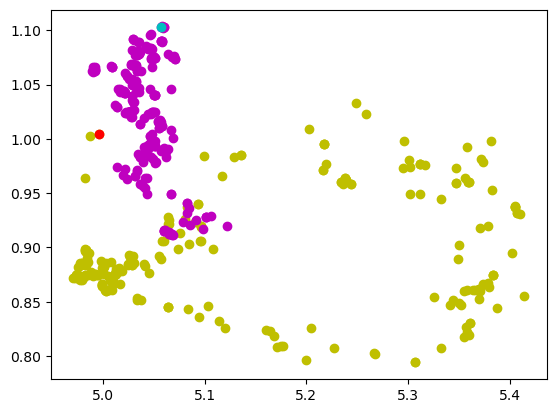

In [65]:
# calc.rと同じ設定　初期点を真の値に
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

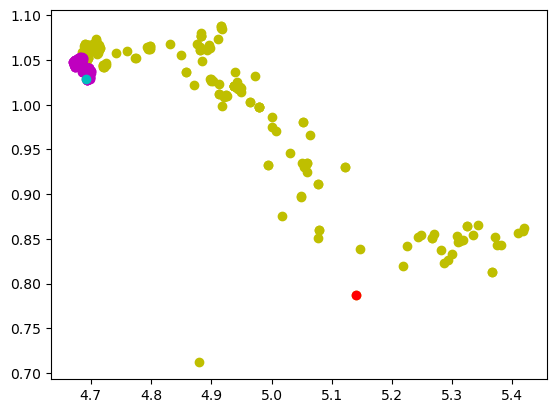

In [62]:
# calc.rと同じ設定　初期点をロバストな値に
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")

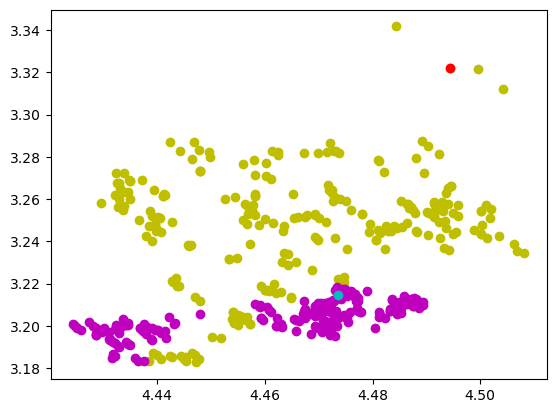

In [56]:
# calc.rと同じ設定 ロバストでない初期点
npres = np.array(res)[0]
half = int(optim_iter/2)
x = npres[:, 0][:half]; y=npres[:,1][:half]

plt.scatter(x,y, color = "y")
plt.scatter(x[1], y[1], color = "r")
x = npres[:, 0][half:]; y=npres[:,1][half:]
plt.scatter(x,y, color ="m")
plt.scatter(x[-1], y[-1], color = "c")